## Import and Config

In [7]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 100
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'DCGAN_cifar10'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.BCELoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    

## Define Model

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 8, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'G_layer_1_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 8, cfg.G_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_2_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_3_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_4' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_4_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_3_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 4),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_4' : torch.nn.Conv2d(cfg.D_DIM * 4, cfg.D_DIM * 8, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'D_layer_4_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            #'flatten' : Flatten(),
            #'D_layer_out' : torch.nn.Linear((cfg.OUTPUT_HEIGHT // 16) * (cfg.OUTPUT_WIDTH // 16) * cfg.D_DIM * 8, 1),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 8, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], padding=0, stride=1, bias=False),
            'D_layer_out_sigmoid' : torch.nn.Sigmoid()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

## Train

Files already downloaded and verified
training start
Iter:50, LossG (fake:2.0445), LossD:0.2857 (real:0.1330, fake:0.1527)
Iter:100, LossG (fake:0.6778), LossD:0.7583 (real:0.0275, fake:0.7308)
Iter:150, LossG (fake:4.0372), LossD:0.9830 (real:0.9555, fake:0.0275)
Iter:200, LossG (fake:3.1378), LossD:0.3853 (real:0.3299, fake:0.0555)
save G >> models/DCGAN_cifar10_G_iter200.pt, D >> models/DCGAN_cifar10_D_iter200.pt
Iter:250, LossG (fake:4.8666), LossD:0.8066 (real:0.7929, fake:0.0137)
Iter:300, LossG (fake:1.1796), LossD:0.6434 (real:0.1236, fake:0.5198)
Iter:350, LossG (fake:4.8030), LossD:0.6318 (real:0.6185, fake:0.0133)
Iter:400, LossG (fake:5.8336), LossD:0.3533 (real:0.3452, fake:0.0080)
save G >> models/DCGAN_cifar10_G_iter400.pt, D >> models/DCGAN_cifar10_D_iter400.pt
Iter:450, LossG (fake:3.2924), LossD:0.0905 (real:0.0238, fake:0.0667)
Iter:500, LossG (fake:4.0585), LossD:0.1579 (real:0.1117, fake:0.0462)
result was saved to >> result/DCGAN_cifar10_result_iter500.jpg


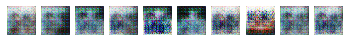

Iter:550, LossG (fake:4.3672), LossD:0.1050 (real:0.0871, fake:0.0179)
Iter:600, LossG (fake:2.4181), LossD:0.2466 (real:0.1423, fake:0.1043)
save G >> models/DCGAN_cifar10_G_iter600.pt, D >> models/DCGAN_cifar10_D_iter600.pt
Iter:650, LossG (fake:2.0703), LossD:0.5833 (real:0.2275, fake:0.3558)
Iter:700, LossG (fake:3.3063), LossD:0.1100 (real:0.0478, fake:0.0622)
Iter:750, LossG (fake:4.4371), LossD:0.1620 (real:0.1299, fake:0.0322)
Iter:800, LossG (fake:2.3581), LossD:0.2078 (real:0.0295, fake:0.1782)
save G >> models/DCGAN_cifar10_G_iter800.pt, D >> models/DCGAN_cifar10_D_iter800.pt
Iter:850, LossG (fake:0.6645), LossD:0.9373 (real:0.0187, fake:0.9187)
Iter:900, LossG (fake:1.7849), LossD:0.2894 (real:0.0170, fake:0.2723)
Iter:950, LossG (fake:2.0787), LossD:0.4957 (real:0.1996, fake:0.2961)
Iter:1000, LossG (fake:1.7932), LossD:0.3043 (real:0.0540, fake:0.2503)
save G >> models/DCGAN_cifar10_G_iter1000.pt, D >> models/DCGAN_cifar10_D_iter1000.pt
result was saved to >> result/DCGAN

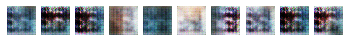

Iter:1050, LossG (fake:2.8693), LossD:0.2217 (real:0.1364, fake:0.0852)
Iter:1100, LossG (fake:3.5273), LossD:0.1638 (real:0.1168, fake:0.0470)
Iter:1150, LossG (fake:4.8894), LossD:0.3766 (real:0.3571, fake:0.0195)
Iter:1200, LossG (fake:4.3324), LossD:0.2546 (real:0.2059, fake:0.0488)
save G >> models/DCGAN_cifar10_G_iter1200.pt, D >> models/DCGAN_cifar10_D_iter1200.pt
Iter:1250, LossG (fake:1.0490), LossD:0.8198 (real:0.2511, fake:0.5687)
Iter:1300, LossG (fake:5.0418), LossD:0.8875 (real:0.8768, fake:0.0107)
Iter:1350, LossG (fake:5.6995), LossD:0.2877 (real:0.2738, fake:0.0139)
Iter:1400, LossG (fake:1.3170), LossD:0.5333 (real:0.0349, fake:0.4984)
save G >> models/DCGAN_cifar10_G_iter1400.pt, D >> models/DCGAN_cifar10_D_iter1400.pt
Iter:1450, LossG (fake:1.0067), LossD:0.7424 (real:0.0635, fake:0.6789)
Iter:1500, LossG (fake:1.9898), LossD:0.2637 (real:0.0313, fake:0.2324)
result was saved to >> result/DCGAN_cifar10_result_iter1500.jpg


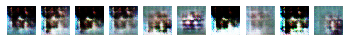

Iter:1550, LossG (fake:3.8881), LossD:0.2486 (real:0.2097, fake:0.0389)
Iter:1600, LossG (fake:2.2385), LossD:0.2359 (real:0.0616, fake:0.1743)
save G >> models/DCGAN_cifar10_G_iter1600.pt, D >> models/DCGAN_cifar10_D_iter1600.pt
Iter:1650, LossG (fake:0.7619), LossD:0.8835 (real:0.0746, fake:0.8089)
Iter:1700, LossG (fake:4.4373), LossD:0.1271 (real:0.1041, fake:0.0230)
Iter:1750, LossG (fake:3.0191), LossD:0.2633 (real:0.1773, fake:0.0860)
Iter:1800, LossG (fake:3.4559), LossD:0.2126 (real:0.1502, fake:0.0624)
save G >> models/DCGAN_cifar10_G_iter1800.pt, D >> models/DCGAN_cifar10_D_iter1800.pt
Iter:1850, LossG (fake:0.8527), LossD:0.8242 (real:0.0160, fake:0.8082)
Iter:1900, LossG (fake:2.7544), LossD:0.5660 (real:0.4588, fake:0.1071)
Iter:1950, LossG (fake:5.0755), LossD:0.3519 (real:0.3426, fake:0.0093)
Iter:2000, LossG (fake:3.8147), LossD:0.0993 (real:0.0506, fake:0.0487)
save G >> models/DCGAN_cifar10_G_iter2000.pt, D >> models/DCGAN_cifar10_D_iter2000.pt
result was saved to >>

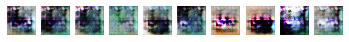

Iter:2050, LossG (fake:1.4801), LossD:0.5615 (real:0.1350, fake:0.4265)
Iter:2100, LossG (fake:2.5351), LossD:0.2268 (real:0.0762, fake:0.1506)
Iter:2150, LossG (fake:2.2298), LossD:0.5081 (real:0.3219, fake:0.1862)
Iter:2200, LossG (fake:6.2891), LossD:0.3363 (real:0.3319, fake:0.0044)
save G >> models/DCGAN_cifar10_G_iter2200.pt, D >> models/DCGAN_cifar10_D_iter2200.pt
Iter:2250, LossG (fake:3.7659), LossD:0.3838 (real:0.3479, fake:0.0359)
Iter:2300, LossG (fake:1.6418), LossD:0.4119 (real:0.1120, fake:0.2999)
Iter:2350, LossG (fake:5.2189), LossD:0.1580 (real:0.1401, fake:0.0179)
Iter:2400, LossG (fake:2.7041), LossD:0.3358 (real:0.1940, fake:0.1418)
save G >> models/DCGAN_cifar10_G_iter2400.pt, D >> models/DCGAN_cifar10_D_iter2400.pt
Iter:2450, LossG (fake:1.3996), LossD:0.4836 (real:0.0118, fake:0.4718)
Iter:2500, LossG (fake:1.9627), LossD:0.3523 (real:0.0757, fake:0.2765)
result was saved to >> result/DCGAN_cifar10_result_iter2500.jpg


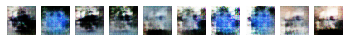

Iter:2550, LossG (fake:1.2099), LossD:0.5928 (real:0.0241, fake:0.5687)
Iter:2600, LossG (fake:2.7520), LossD:0.3041 (real:0.1970, fake:0.1071)
save G >> models/DCGAN_cifar10_G_iter2600.pt, D >> models/DCGAN_cifar10_D_iter2600.pt
Iter:2650, LossG (fake:1.8116), LossD:0.3615 (real:0.0364, fake:0.3251)
Iter:2700, LossG (fake:0.8959), LossD:0.8019 (real:0.0392, fake:0.7627)
Iter:2750, LossG (fake:3.5915), LossD:0.1109 (real:0.0542, fake:0.0566)
Iter:2800, LossG (fake:3.6908), LossD:0.1485 (real:0.0656, fake:0.0829)
save G >> models/DCGAN_cifar10_G_iter2800.pt, D >> models/DCGAN_cifar10_D_iter2800.pt
Iter:2850, LossG (fake:3.8999), LossD:0.2678 (real:0.2342, fake:0.0335)
Iter:2900, LossG (fake:5.1286), LossD:0.2516 (real:0.2371, fake:0.0145)
Iter:2950, LossG (fake:5.5599), LossD:0.7658 (real:0.7574, fake:0.0084)
Iter:3000, LossG (fake:0.4669), LossD:1.4554 (real:0.0138, fake:1.4416)
save G >> models/DCGAN_cifar10_G_iter3000.pt, D >> models/DCGAN_cifar10_D_iter3000.pt
result was saved to >>

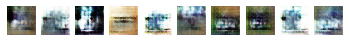

Iter:3050, LossG (fake:3.7090), LossD:0.0866 (real:0.0409, fake:0.0457)
Iter:3100, LossG (fake:5.9743), LossD:0.2097 (real:0.2016, fake:0.0081)
Iter:3150, LossG (fake:2.0224), LossD:0.3858 (real:0.0648, fake:0.3210)
Iter:3200, LossG (fake:5.4350), LossD:0.5637 (real:0.5540, fake:0.0098)
save G >> models/DCGAN_cifar10_G_iter3200.pt, D >> models/DCGAN_cifar10_D_iter3200.pt
Iter:3250, LossG (fake:5.9333), LossD:0.6116 (real:0.6047, fake:0.0069)
Iter:3300, LossG (fake:2.5132), LossD:0.4801 (real:0.3539, fake:0.1261)
Iter:3350, LossG (fake:5.3579), LossD:0.1426 (real:0.1236, fake:0.0190)
Iter:3400, LossG (fake:2.1470), LossD:0.3388 (real:0.1153, fake:0.2235)
save G >> models/DCGAN_cifar10_G_iter3400.pt, D >> models/DCGAN_cifar10_D_iter3400.pt
Iter:3450, LossG (fake:4.0664), LossD:0.6974 (real:0.6580, fake:0.0394)
Iter:3500, LossG (fake:1.2560), LossD:0.6747 (real:0.1076, fake:0.5672)
result was saved to >> result/DCGAN_cifar10_result_iter3500.jpg


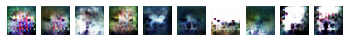

Iter:3550, LossG (fake:2.0969), LossD:0.4529 (real:0.2380, fake:0.2149)
Iter:3600, LossG (fake:2.6329), LossD:0.3012 (real:0.0968, fake:0.2045)
save G >> models/DCGAN_cifar10_G_iter3600.pt, D >> models/DCGAN_cifar10_D_iter3600.pt
Iter:3650, LossG (fake:1.8055), LossD:0.4931 (real:0.1516, fake:0.3415)
Iter:3700, LossG (fake:4.3619), LossD:0.3056 (real:0.2814, fake:0.0242)
Iter:3750, LossG (fake:3.6934), LossD:0.5629 (real:0.5070, fake:0.0560)
Iter:3800, LossG (fake:2.4202), LossD:0.3174 (real:0.1404, fake:0.1770)
save G >> models/DCGAN_cifar10_G_iter3800.pt, D >> models/DCGAN_cifar10_D_iter3800.pt
Iter:3850, LossG (fake:3.1000), LossD:0.2290 (real:0.1467, fake:0.0823)
Iter:3900, LossG (fake:5.2867), LossD:0.5036 (real:0.4939, fake:0.0097)
Iter:3950, LossG (fake:2.7325), LossD:0.3637 (real:0.2484, fake:0.1153)
Iter:4000, LossG (fake:3.0194), LossD:0.1749 (real:0.0545, fake:0.1204)
save G >> models/DCGAN_cifar10_G_iter4000.pt, D >> models/DCGAN_cifar10_D_iter4000.pt
result was saved to >>

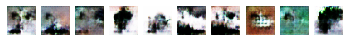

Iter:4050, LossG (fake:1.8389), LossD:0.5655 (real:0.1818, fake:0.3837)
Iter:4100, LossG (fake:1.4709), LossD:0.5162 (real:0.0492, fake:0.4669)
Iter:4150, LossG (fake:1.4085), LossD:0.7490 (real:0.1789, fake:0.5701)
Iter:4200, LossG (fake:2.9875), LossD:0.6503 (real:0.5278, fake:0.1225)
save G >> models/DCGAN_cifar10_G_iter4200.pt, D >> models/DCGAN_cifar10_D_iter4200.pt
Iter:4250, LossG (fake:1.9332), LossD:0.4529 (real:0.1672, fake:0.2857)
Iter:4300, LossG (fake:5.6137), LossD:0.0419 (real:0.0330, fake:0.0089)
Iter:4350, LossG (fake:3.5143), LossD:0.3682 (real:0.3103, fake:0.0579)
Iter:4400, LossG (fake:3.3656), LossD:0.3203 (real:0.2552, fake:0.0651)
save G >> models/DCGAN_cifar10_G_iter4400.pt, D >> models/DCGAN_cifar10_D_iter4400.pt
Iter:4450, LossG (fake:2.6594), LossD:0.4698 (real:0.3429, fake:0.1269)
Iter:4500, LossG (fake:1.9153), LossD:0.5015 (real:0.2165, fake:0.2850)
result was saved to >> result/DCGAN_cifar10_result_iter4500.jpg


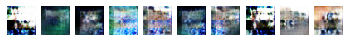

Iter:4550, LossG (fake:2.7600), LossD:0.3287 (real:0.1585, fake:0.1702)
Iter:4600, LossG (fake:4.9220), LossD:0.1750 (real:0.1534, fake:0.0216)
save G >> models/DCGAN_cifar10_G_iter4600.pt, D >> models/DCGAN_cifar10_D_iter4600.pt
Iter:4650, LossG (fake:2.1351), LossD:0.4354 (real:0.1963, fake:0.2391)
Iter:4700, LossG (fake:0.4930), LossD:1.3009 (real:0.0352, fake:1.2657)
Iter:4750, LossG (fake:3.5523), LossD:0.1007 (real:0.0590, fake:0.0417)
Iter:4800, LossG (fake:4.4954), LossD:0.3310 (real:0.2967, fake:0.0343)
save G >> models/DCGAN_cifar10_G_iter4800.pt, D >> models/DCGAN_cifar10_D_iter4800.pt
Iter:4850, LossG (fake:4.8174), LossD:0.8409 (real:0.8222, fake:0.0188)
Iter:4900, LossG (fake:6.8974), LossD:0.1472 (real:0.1439, fake:0.0033)
Iter:4950, LossG (fake:3.5425), LossD:0.1991 (real:0.1319, fake:0.0672)
Iter:5000, LossG (fake:4.5671), LossD:0.1987 (real:0.1705, fake:0.0281)
save G >> models/DCGAN_cifar10_G_iter5000.pt, D >> models/DCGAN_cifar10_D_iter5000.pt
result was saved to >>

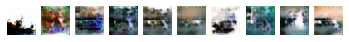

Iter:5050, LossG (fake:2.6213), LossD:0.1466 (real:0.0186, fake:0.1280)
Iter:5100, LossG (fake:3.6007), LossD:0.1705 (real:0.1078, fake:0.0627)
Iter:5150, LossG (fake:6.0148), LossD:0.4364 (real:0.4287, fake:0.0077)
Iter:5200, LossG (fake:2.6049), LossD:0.2611 (real:0.0918, fake:0.1693)
save G >> models/DCGAN_cifar10_G_iter5200.pt, D >> models/DCGAN_cifar10_D_iter5200.pt
Iter:5250, LossG (fake:5.4791), LossD:1.0256 (real:1.0165, fake:0.0092)
Iter:5300, LossG (fake:4.6740), LossD:0.3948 (real:0.3549, fake:0.0399)
Iter:5350, LossG (fake:4.8599), LossD:0.7111 (real:0.6838, fake:0.0273)
Iter:5400, LossG (fake:3.5653), LossD:0.5081 (real:0.4494, fake:0.0587)
save G >> models/DCGAN_cifar10_G_iter5400.pt, D >> models/DCGAN_cifar10_D_iter5400.pt
Iter:5450, LossG (fake:4.5515), LossD:0.1105 (real:0.0481, fake:0.0624)
Iter:5500, LossG (fake:1.0521), LossD:0.7059 (real:0.0586, fake:0.6472)
result was saved to >> result/DCGAN_cifar10_result_iter5500.jpg


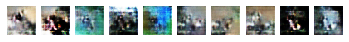

Iter:5550, LossG (fake:3.3280), LossD:0.3096 (real:0.2370, fake:0.0726)
Iter:5600, LossG (fake:8.3711), LossD:0.6166 (real:0.6159, fake:0.0007)
save G >> models/DCGAN_cifar10_G_iter5600.pt, D >> models/DCGAN_cifar10_D_iter5600.pt
Iter:5650, LossG (fake:3.0902), LossD:0.3069 (real:0.1886, fake:0.1183)
Iter:5700, LossG (fake:4.2944), LossD:0.1171 (real:0.0819, fake:0.0352)
Iter:5750, LossG (fake:3.8894), LossD:0.1738 (real:0.1098, fake:0.0640)
Iter:5800, LossG (fake:1.9685), LossD:0.3940 (real:0.0529, fake:0.3412)
save G >> models/DCGAN_cifar10_G_iter5800.pt, D >> models/DCGAN_cifar10_D_iter5800.pt
Iter:5850, LossG (fake:4.1603), LossD:0.2505 (real:0.1976, fake:0.0529)
Iter:5900, LossG (fake:2.3538), LossD:0.2784 (real:0.0641, fake:0.2144)
Iter:5950, LossG (fake:3.7712), LossD:0.1276 (real:0.0756, fake:0.0520)
Iter:6000, LossG (fake:2.9510), LossD:0.1197 (real:0.0258, fake:0.0940)
save G >> models/DCGAN_cifar10_G_iter6000.pt, D >> models/DCGAN_cifar10_D_iter6000.pt
result was saved to >>

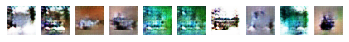

Iter:6050, LossG (fake:2.0481), LossD:0.5872 (real:0.3286, fake:0.2586)
Iter:6100, LossG (fake:2.2556), LossD:0.3239 (real:0.0950, fake:0.2290)
Iter:6150, LossG (fake:2.0865), LossD:0.4400 (real:0.1179, fake:0.3221)
Iter:6200, LossG (fake:5.7222), LossD:0.0768 (real:0.0679, fake:0.0090)
save G >> models/DCGAN_cifar10_G_iter6200.pt, D >> models/DCGAN_cifar10_D_iter6200.pt
Iter:6250, LossG (fake:3.2142), LossD:0.1289 (real:0.0641, fake:0.0648)
Iter:6300, LossG (fake:3.5619), LossD:0.1673 (real:0.0798, fake:0.0876)
Iter:6350, LossG (fake:4.9769), LossD:0.7516 (real:0.7384, fake:0.0132)
Iter:6400, LossG (fake:3.2411), LossD:0.4459 (real:0.3720, fake:0.0739)
save G >> models/DCGAN_cifar10_G_iter6400.pt, D >> models/DCGAN_cifar10_D_iter6400.pt
Iter:6450, LossG (fake:4.8904), LossD:0.4374 (real:0.4165, fake:0.0209)
Iter:6500, LossG (fake:2.8131), LossD:0.2969 (real:0.0991, fake:0.1978)
result was saved to >> result/DCGAN_cifar10_result_iter6500.jpg


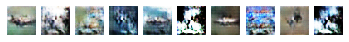

Iter:6550, LossG (fake:3.3828), LossD:0.2240 (real:0.1456, fake:0.0783)
Iter:6600, LossG (fake:2.1432), LossD:0.2670 (real:0.0656, fake:0.2013)
save G >> models/DCGAN_cifar10_G_iter6600.pt, D >> models/DCGAN_cifar10_D_iter6600.pt
Iter:6650, LossG (fake:0.9666), LossD:0.8826 (real:0.0956, fake:0.7870)
Iter:6700, LossG (fake:3.5225), LossD:0.0820 (real:0.0177, fake:0.0643)
Iter:6750, LossG (fake:3.3615), LossD:0.2160 (real:0.1388, fake:0.0773)
Iter:6800, LossG (fake:0.7943), LossD:1.0564 (real:0.0687, fake:0.9877)
save G >> models/DCGAN_cifar10_G_iter6800.pt, D >> models/DCGAN_cifar10_D_iter6800.pt
Iter:6850, LossG (fake:4.1757), LossD:0.6725 (real:0.6463, fake:0.0262)
Iter:6900, LossG (fake:3.6717), LossD:0.2394 (real:0.1930, fake:0.0465)
Iter:6950, LossG (fake:2.5596), LossD:0.2336 (real:0.0277, fake:0.2059)
Iter:7000, LossG (fake:2.2534), LossD:0.2416 (real:0.0082, fake:0.2334)
save G >> models/DCGAN_cifar10_G_iter7000.pt, D >> models/DCGAN_cifar10_D_iter7000.pt
result was saved to >>

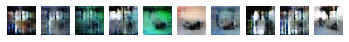

Iter:7050, LossG (fake:5.7089), LossD:0.3914 (real:0.3812, fake:0.0102)
Iter:7100, LossG (fake:1.9466), LossD:0.3708 (real:0.0563, fake:0.3146)
Iter:7150, LossG (fake:4.0541), LossD:0.4837 (real:0.4513, fake:0.0324)
Iter:7200, LossG (fake:5.4689), LossD:0.1752 (real:0.1673, fake:0.0078)
save G >> models/DCGAN_cifar10_G_iter7200.pt, D >> models/DCGAN_cifar10_D_iter7200.pt
Iter:7250, LossG (fake:0.4911), LossD:1.3474 (real:0.0140, fake:1.3334)
Iter:7300, LossG (fake:1.9965), LossD:0.4597 (real:0.1621, fake:0.2976)
Iter:7350, LossG (fake:1.8121), LossD:0.4923 (real:0.0638, fake:0.4285)
Iter:7400, LossG (fake:1.5992), LossD:0.4612 (real:0.0298, fake:0.4315)
save G >> models/DCGAN_cifar10_G_iter7400.pt, D >> models/DCGAN_cifar10_D_iter7400.pt
Iter:7450, LossG (fake:1.5827), LossD:0.5863 (real:0.0369, fake:0.5494)
Iter:7500, LossG (fake:3.6285), LossD:0.1867 (real:0.1171, fake:0.0696)
result was saved to >> result/DCGAN_cifar10_result_iter7500.jpg


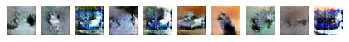

Iter:7550, LossG (fake:3.8002), LossD:0.3968 (real:0.3636, fake:0.0332)
Iter:7600, LossG (fake:4.6546), LossD:0.2629 (real:0.2285, fake:0.0344)
save G >> models/DCGAN_cifar10_G_iter7600.pt, D >> models/DCGAN_cifar10_D_iter7600.pt
Iter:7650, LossG (fake:5.7311), LossD:2.5574 (real:2.5489, fake:0.0085)
Iter:7700, LossG (fake:4.8457), LossD:0.1562 (real:0.1291, fake:0.0271)
Iter:7750, LossG (fake:5.0909), LossD:0.6457 (real:0.6294, fake:0.0164)
Iter:7800, LossG (fake:4.1892), LossD:0.6491 (real:0.6185, fake:0.0306)
save G >> models/DCGAN_cifar10_G_iter7800.pt, D >> models/DCGAN_cifar10_D_iter7800.pt
Iter:7850, LossG (fake:3.3079), LossD:0.6944 (real:0.6241, fake:0.0704)
Iter:7900, LossG (fake:5.8574), LossD:0.6247 (real:0.6179, fake:0.0068)
Iter:7950, LossG (fake:1.7916), LossD:0.2964 (real:0.0184, fake:0.2780)
Iter:8000, LossG (fake:2.0678), LossD:0.2394 (real:0.0180, fake:0.2214)
save G >> models/DCGAN_cifar10_G_iter8000.pt, D >> models/DCGAN_cifar10_D_iter8000.pt
result was saved to >>

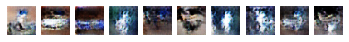

Iter:8050, LossG (fake:4.3059), LossD:0.4288 (real:0.3925, fake:0.0364)
Iter:8100, LossG (fake:2.5781), LossD:0.4728 (real:0.3465, fake:0.1263)
Iter:8150, LossG (fake:1.4428), LossD:0.4908 (real:0.0036, fake:0.4872)
Iter:8200, LossG (fake:1.6349), LossD:0.4893 (real:0.1002, fake:0.3892)
save G >> models/DCGAN_cifar10_G_iter8200.pt, D >> models/DCGAN_cifar10_D_iter8200.pt
Iter:8250, LossG (fake:2.3909), LossD:0.2574 (real:0.0558, fake:0.2016)
Iter:8300, LossG (fake:3.7568), LossD:0.1434 (real:0.0902, fake:0.0532)
Iter:8350, LossG (fake:5.7830), LossD:0.4681 (real:0.4461, fake:0.0220)
Iter:8400, LossG (fake:2.7929), LossD:0.2998 (real:0.1026, fake:0.1972)
save G >> models/DCGAN_cifar10_G_iter8400.pt, D >> models/DCGAN_cifar10_D_iter8400.pt
Iter:8450, LossG (fake:2.3158), LossD:0.5610 (real:0.3489, fake:0.2121)
Iter:8500, LossG (fake:2.1311), LossD:0.2886 (real:0.0664, fake:0.2222)
result was saved to >> result/DCGAN_cifar10_result_iter8500.jpg


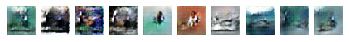

Iter:8550, LossG (fake:1.6049), LossD:0.3948 (real:0.0332, fake:0.3616)
Iter:8600, LossG (fake:5.2384), LossD:0.4321 (real:0.4193, fake:0.0128)
save G >> models/DCGAN_cifar10_G_iter8600.pt, D >> models/DCGAN_cifar10_D_iter8600.pt
Iter:8650, LossG (fake:4.2610), LossD:0.5897 (real:0.5620, fake:0.0277)
Iter:8700, LossG (fake:3.0605), LossD:0.5547 (real:0.4481, fake:0.1066)
Iter:8750, LossG (fake:2.8603), LossD:0.4795 (real:0.3626, fake:0.1169)
Iter:8800, LossG (fake:1.5793), LossD:0.5420 (real:0.0396, fake:0.5024)
save G >> models/DCGAN_cifar10_G_iter8800.pt, D >> models/DCGAN_cifar10_D_iter8800.pt
Iter:8850, LossG (fake:3.9725), LossD:0.0887 (real:0.0306, fake:0.0581)
Iter:8900, LossG (fake:2.3104), LossD:0.3201 (real:0.1038, fake:0.2163)
Iter:8950, LossG (fake:5.6986), LossD:0.3922 (real:0.3838, fake:0.0084)
Iter:9000, LossG (fake:3.6522), LossD:0.2274 (real:0.1616, fake:0.0657)
save G >> models/DCGAN_cifar10_G_iter9000.pt, D >> models/DCGAN_cifar10_D_iter9000.pt
result was saved to >>

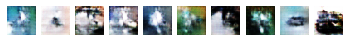

Iter:9050, LossG (fake:5.6410), LossD:0.2854 (real:0.2776, fake:0.0078)
Iter:9100, LossG (fake:3.5322), LossD:0.0894 (real:0.0234, fake:0.0660)
Iter:9150, LossG (fake:6.4000), LossD:0.1604 (real:0.1553, fake:0.0051)
Iter:9200, LossG (fake:3.6880), LossD:0.2742 (real:0.2206, fake:0.0536)
save G >> models/DCGAN_cifar10_G_iter9200.pt, D >> models/DCGAN_cifar10_D_iter9200.pt
Iter:9250, LossG (fake:1.5481), LossD:0.5591 (real:0.1134, fake:0.4457)
Iter:9300, LossG (fake:5.6016), LossD:0.1888 (real:0.1814, fake:0.0074)
Iter:9350, LossG (fake:2.3648), LossD:0.2232 (real:0.0661, fake:0.1571)
Iter:9400, LossG (fake:4.3478), LossD:0.4930 (real:0.4710, fake:0.0219)
save G >> models/DCGAN_cifar10_G_iter9400.pt, D >> models/DCGAN_cifar10_D_iter9400.pt
Iter:9450, LossG (fake:3.5232), LossD:0.3083 (real:0.2539, fake:0.0544)
Iter:9500, LossG (fake:3.4801), LossD:0.1126 (real:0.0410, fake:0.0716)
result was saved to >> result/DCGAN_cifar10_result_iter9500.jpg


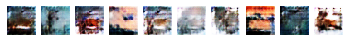

Iter:9550, LossG (fake:5.3437), LossD:0.1851 (real:0.1731, fake:0.0120)
Iter:9600, LossG (fake:1.8725), LossD:0.3427 (real:0.0549, fake:0.2878)
save G >> models/DCGAN_cifar10_G_iter9600.pt, D >> models/DCGAN_cifar10_D_iter9600.pt
Iter:9650, LossG (fake:1.0902), LossD:0.8375 (real:0.0486, fake:0.7889)
Iter:9700, LossG (fake:4.5097), LossD:0.7413 (real:0.7091, fake:0.0322)
Iter:9750, LossG (fake:0.5850), LossD:1.1405 (real:0.0154, fake:1.1250)
Iter:9800, LossG (fake:5.7738), LossD:0.2818 (real:0.2756, fake:0.0062)
save G >> models/DCGAN_cifar10_G_iter9800.pt, D >> models/DCGAN_cifar10_D_iter9800.pt
Iter:9850, LossG (fake:2.3822), LossD:0.3666 (real:0.1445, fake:0.2221)
Iter:9900, LossG (fake:3.5888), LossD:0.1190 (real:0.0537, fake:0.0653)
Iter:9950, LossG (fake:2.8284), LossD:0.2624 (real:0.1051, fake:0.1573)
Iter:10000, LossG (fake:5.5484), LossD:0.4452 (real:0.4360, fake:0.0093)
save G >> models/DCGAN_cifar10_G_iter10000.pt, D >> models/DCGAN_cifar10_D_iter10000.pt
result was saved to

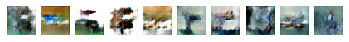

final paramters were saved to G >> models/DCGAN_cifar10_G_final.pt, D >> models/DCGAN_cifar10_D_final.pt
loss was saved to >> result/DCGAN_cifar10_loss.csv


In [3]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data
    train_ys = trainset.targets

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        # forward
        Gz = G(z)
        #Gz = torch.reshape(Gz, [cfg.TRAIN.MINIBATCH, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

        D_real = D(Xs)[..., 0, 0, 0]
        D_fake = D(Gz)[..., 0, 0, 0]

        # update D
        loss_D_real = cfg.TRAIN.LOSS_FUNCTION(D_real, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D_fake = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.zeros(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()

        # update G
        opt_G.zero_grad()
        loss_G = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_G.backward()
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/DCGAN_cifar10_result_1.jpg


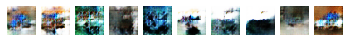

result was saved to >> result/DCGAN_cifar10_result_2.jpg


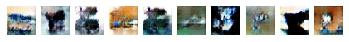

In [8]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
